# **Multivariate Time Series Forecasting of Wheat Yield in Australia Using LSTM**

This notebook shows the code for my Final Year Project: *Utilizing the Australian Actuaries Climate Index to Predict Wheat Yield in Australia: A Comparative Analysis of Vector Autoregression and Recurrent Neural Network*

In [3]:
import os
os.getcwd()

'/home/matthewfarant123/apu-fyp'

# Data Pre-Processing

In [4]:
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import interpolate
from pandasql import sqldf

In [5]:
#Import The AACI Dataset
df_all = pd.read_csv('aaci_australia.csv')
df_cdd = pd.read_csv('aaci_cdd_australia.csv')
df_rainfall = pd.read_csv('aaci_rainfall_australia.csv')
df_sealevel = pd.read_csv('aaci_sealevel_australia.csv')
df_temphigh = pd.read_csv('aaci_temphigh_australia.csv')
df_templow = pd.read_csv('aaci_templow_australia.csv')
df_wind = pd.read_csv('aaci_wind_australia.csv')

In [6]:
#Unpivot the AACI data
sqlkey = lambda q : sqldf(q,globals())
query = '''
WITH grouped AS (
  -- ALL
  SELECT Year,
    Region || '_ALL' Region,
    AVG(AACI) AS AACI
  FROM df_all
  GROUP BY 1,2

  UNION ALL
  -- CDD
  SELECT Year,
    Region || '_CDD' Region,
    AVG(AACI) AS AACI
  FROM df_cdd
  GROUP BY 1,2

  UNION ALL
  --RAINFALL
  SELECT Year,
    Region || '_RF' Region,
    AVG(AACI) AS AACI
  FROM df_rainfall
  GROUP BY 1,2

  UNION ALL
  --SEALEVEL
  SELECT Year,
    Region || '_SL' Region,
    AVG(AACI) AS AACI
  FROM df_sealevel
  GROUP BY 1,2

  UNION ALL
  --TEMPHIGH
  SELECT Year,
    Region || '_TH' Region,
    AVG(AACI) AS AACI
  FROM df_temphigh
  GROUP BY 1,2

  UNION ALL
  --TEMPLOW
  SELECT Year,
    Region || '_TL' Region,
    AVG(AACI) AS AACI
  FROM df_templow
  GROUP BY 1,2

  UNION ALL
  --WIND
  SELECT Year,
    Region || '_WI' Region,
    AVG(AACI) AS AACI
  FROM df_wind
  GROUP BY 1,2
), 
transposed AS (
  SELECT Year,
    --ALL
    CASE WHEN Region = 'AU_ALL' THEN AACI END AS AU_ALL,
    CASE WHEN Region = 'CS_ALL' THEN AACI END AS CS_ALL,
    CASE WHEN Region = 'EN_ALL' THEN AACI END AS EN_ALL,
    CASE WHEN Region = 'ES_ALL' THEN AACI END AS ES_ALL,
    CASE WHEN Region = 'MB_ALL' THEN AACI END AS MB_ALL,
    CASE WHEN Region = 'MN_ALL' THEN AACI END AS MN_ALL,
    CASE WHEN Region = 'RN_ALL' THEN AACI END AS RN_ALL,
    CASE WHEN Region = 'RS_ALL' THEN AACI END AS RS_ALL,
    CASE WHEN Region = 'SE_ALL' THEN AACI END AS SE_ALL,
    CASE WHEN Region = 'ST_ALL' THEN AACI END AS ST_ALL,
    CASE WHEN Region = 'SV_ALL' THEN AACI END AS SV_ALL,
    CASE WHEN Region = 'SW_ALL' THEN AACI END AS SW_ALL,
    CASE WHEN Region = 'WT_ALL' THEN AACI END AS WT_ALL,
    --CDD
    CASE WHEN Region = 'AU_CDD' THEN AACI END AS AU_CDD,
    CASE WHEN Region = 'CS_CDD' THEN AACI END AS CS_CDD,
    CASE WHEN Region = 'EN_CDD' THEN AACI END AS EN_CDD,
    CASE WHEN Region = 'ES_CDD' THEN AACI END AS ES_CDD,
    CASE WHEN Region = 'MB_CDD' THEN AACI END AS MB_CDD,
    CASE WHEN Region = 'MN_CDD' THEN AACI END AS MN_CDD,
    CASE WHEN Region = 'RN_CDD' THEN AACI END AS RN_CDD,
    CASE WHEN Region = 'RS_CDD' THEN AACI END AS RS_CDD,
    CASE WHEN Region = 'SE_CDD' THEN AACI END AS SE_CDD,
    CASE WHEN Region = 'ST_CDD' THEN AACI END AS ST_CDD,
    CASE WHEN Region = 'SV_CDD' THEN AACI END AS SV_CDD,
    CASE WHEN Region = 'SW_CDD' THEN AACI END AS SW_CDD,
    CASE WHEN Region = 'WT_CDD' THEN AACI END AS WT_CDD,
    --RAINFALL
    CASE WHEN Region = 'AU_RF' THEN AACI END AS AU_RF,
    CASE WHEN Region = 'CS_RF' THEN AACI END AS CS_RF,
    CASE WHEN Region = 'EN_RF' THEN AACI END AS EN_RF,
    CASE WHEN Region = 'ES_RF' THEN AACI END AS ES_RF,
    CASE WHEN Region = 'MB_RF' THEN AACI END AS MB_RF,
    CASE WHEN Region = 'MN_RF' THEN AACI END AS MN_RF,
    CASE WHEN Region = 'RN_RF' THEN AACI END AS RN_RF,
    CASE WHEN Region = 'RS_RF' THEN AACI END AS RS_RF,
    CASE WHEN Region = 'SE_RF' THEN AACI END AS SE_RF,
    CASE WHEN Region = 'ST_RF' THEN AACI END AS ST_RF,
    CASE WHEN Region = 'SV_RF' THEN AACI END AS SV_RF,
    CASE WHEN Region = 'SW_RF' THEN AACI END AS SW_RF,
    CASE WHEN Region = 'WT_RF' THEN AACI END AS WT_RF,
    --SEALEVEL
    CASE WHEN Region = 'AU_SL' THEN AACI END AS AU_SL,
    CASE WHEN Region = 'CS_SL' THEN AACI END AS CS_SL,
    CASE WHEN Region = 'EN_SL' THEN AACI END AS EN_SL,
    CASE WHEN Region = 'ES_SL' THEN AACI END AS ES_SL,
    CASE WHEN Region = 'MB_SL' THEN AACI END AS MB_SL,
    CASE WHEN Region = 'MN_SL' THEN AACI END AS MN_SL,
    CASE WHEN Region = 'RN_SL' THEN AACI END AS RN_SL,
    CASE WHEN Region = 'RS_SL' THEN AACI END AS RS_SL,
    CASE WHEN Region = 'SE_SL' THEN AACI END AS SE_SL,
    CASE WHEN Region = 'ST_SL' THEN AACI END AS ST_SL,
    CASE WHEN Region = 'SV_SL' THEN AACI END AS SV_SL,
    CASE WHEN Region = 'SW_SL' THEN AACI END AS SW_SL,
    CASE WHEN Region = 'WT_SL' THEN AACI END AS WT_SL,
    --TEMPHIGH
    CASE WHEN Region = 'AU_TH' THEN AACI END AS AU_TH,
    CASE WHEN Region = 'CS_TH' THEN AACI END AS CS_TH,
    CASE WHEN Region = 'EN_TH' THEN AACI END AS EN_TH,
    CASE WHEN Region = 'ES_TH' THEN AACI END AS ES_TH,
    CASE WHEN Region = 'MB_TH' THEN AACI END AS MB_TH,
    CASE WHEN Region = 'MN_TH' THEN AACI END AS MN_TH,
    CASE WHEN Region = 'RN_TH' THEN AACI END AS RN_TH,
    CASE WHEN Region = 'RS_TH' THEN AACI END AS RS_TH,
    CASE WHEN Region = 'SE_TH' THEN AACI END AS SE_TH,
    CASE WHEN Region = 'ST_TH' THEN AACI END AS ST_TH,
    CASE WHEN Region = 'SV_TH' THEN AACI END AS SV_TH,
    CASE WHEN Region = 'SW_TH' THEN AACI END AS SW_TH,
    CASE WHEN Region = 'WT_TH' THEN AACI END AS WT_TH,
    --TEMPLOW
    CASE WHEN Region = 'AU_TL' THEN AACI END AS AU_TL,
    CASE WHEN Region = 'CS_TL' THEN AACI END AS CS_TL,
    CASE WHEN Region = 'EN_TL' THEN AACI END AS EN_TL,
    CASE WHEN Region = 'ES_TL' THEN AACI END AS ES_TL,
    CASE WHEN Region = 'MB_TL' THEN AACI END AS MB_TL,
    CASE WHEN Region = 'MN_TL' THEN AACI END AS MN_TL,
    CASE WHEN Region = 'RN_TL' THEN AACI END AS RN_TL,
    CASE WHEN Region = 'RS_TL' THEN AACI END AS RS_TL,
    CASE WHEN Region = 'SE_TL' THEN AACI END AS SE_TL,
    CASE WHEN Region = 'ST_TL' THEN AACI END AS ST_TL,
    CASE WHEN Region = 'SV_TL' THEN AACI END AS SV_TL,
    CASE WHEN Region = 'SW_TL' THEN AACI END AS SW_TL,
    CASE WHEN Region = 'WT_TL' THEN AACI END AS WT_TL,
    --WIND
    CASE WHEN Region = 'AU_WI' THEN AACI END AS AU_WI,
    CASE WHEN Region = 'CS_WI' THEN AACI END AS CS_WI,
    CASE WHEN Region = 'EN_WI' THEN AACI END AS EN_WI,
    CASE WHEN Region = 'ES_WI' THEN AACI END AS ES_WI,
    CASE WHEN Region = 'MB_WI' THEN AACI END AS MB_WI,
    CASE WHEN Region = 'MN_WI' THEN AACI END AS MN_WI,
    CASE WHEN Region = 'RN_WI' THEN AACI END AS RN_WI,
    CASE WHEN Region = 'RS_WI' THEN AACI END AS RS_WI,
    CASE WHEN Region = 'SE_WI' THEN AACI END AS SE_WI,
    CASE WHEN Region = 'ST_WI' THEN AACI END AS ST_WI,
    CASE WHEN Region = 'SV_WI' THEN AACI END AS SV_WI,
    CASE WHEN Region = 'SW_WI' THEN AACI END AS SW_WI,
    CASE WHEN Region = 'WT_WI' THEN AACI END AS WT_WI
  FROM grouped
)
SELECT Year,
    --ALL
      SUM(AU_ALL) AS AU_ALL,
      SUM(CS_ALL) AS CS_ALL,
      SUM(EN_ALL) AS EN_ALL,
      SUM(ES_ALL) AS ES_ALL,
      SUM(MB_ALL) AS MB_ALL,
      SUM(MN_ALL) AS MN_ALL,
      SUM(RN_ALL) AS RN_ALL,
      SUM(RS_ALL) AS RS_ALL,
      SUM(SE_ALL) AS SE_ALL,
      SUM(ST_ALL) AS ST_ALL,
      SUM(SV_ALL) AS SV_ALL,
      SUM(SW_ALL) AS SW_ALL,
      SUM(WT_ALL) AS WT_ALL,
    --CDD
      SUM(AU_CDD) AS AU_CDD,
      SUM(CS_CDD) AS CS_CDD,
      SUM(EN_CDD) AS EN_CDD,
      SUM(ES_CDD) AS ES_CDD,
      SUM(MB_CDD) AS MB_CDD,
      SUM(MN_CDD) AS MN_CDD,
      SUM(RN_CDD) AS RN_CDD,
      SUM(RS_CDD) AS RS_CDD,
      SUM(SE_CDD) AS SE_CDD,
      SUM(ST_CDD) AS ST_CDD,
      SUM(SV_CDD) AS SV_CDD,
      SUM(SW_CDD) AS SW_CDD,
      SUM(WT_CDD) AS WT_CDD,
    --RAINFALL
      SUM(AU_RF) AS AU_RF,
      SUM(CS_RF) AS CS_RF,
      SUM(EN_RF) AS EN_RF,
      SUM(ES_RF) AS ES_RF,
      SUM(MB_RF) AS MB_RF,
      SUM(MN_RF) AS MN_RF,
      SUM(RN_RF) AS RN_RF,
      SUM(RS_RF) AS RS_RF,
      SUM(SE_RF) AS SE_RF,
      SUM(ST_RF) AS ST_RF,
      SUM(SV_RF) AS SV_RF,
      SUM(SW_RF) AS SW_RF,
      SUM(WT_RF) AS WT_RF,
    --SEALEVEL
      SUM(AU_SL) AS AU_SL,
      SUM(CS_SL) AS CS_SL,
      SUM(EN_SL) AS EN_SL,
      SUM(ES_SL) AS ES_SL,
      SUM(MB_SL) AS MB_SL,
      SUM(MN_SL) AS MN_SL,
      SUM(RN_SL) AS RN_SL,
      SUM(RS_SL) AS RS_SL,
      SUM(SE_SL) AS SE_SL,
      SUM(ST_SL) AS ST_SL,
      SUM(SV_SL) AS SV_SL,
      SUM(SW_SL) AS SW_SL,
      SUM(WT_SL) AS WT_SL,
    --TEMPHIGH
      SUM(AU_TH) AS AU_TH,
      SUM(CS_TH) AS CS_TH,
      SUM(EN_TH) AS EN_TH,
      SUM(ES_TH) AS ES_TH,
      SUM(MB_TH) AS MB_TH,
      SUM(MN_TH) AS MN_TH,
      SUM(RN_TH) AS RN_TH,
      SUM(RS_TH) AS RS_TH,
      SUM(SE_TH) AS SE_TH,
      SUM(ST_TH) AS ST_TH,
      SUM(SV_TH) AS SV_TH,
      SUM(SW_TH) AS SW_TH,
      SUM(WT_TH) AS WT_TH,
    --TEMPLOW
      SUM(AU_TL) AS AU_TL,
      SUM(CS_TL) AS CS_TL,
      SUM(EN_TL) AS EN_TL,
      SUM(ES_TL) AS ES_TL,
      SUM(MB_TL) AS MB_TL,
      SUM(MN_TL) AS MN_TL,
      SUM(RN_TL) AS RN_TL,
      SUM(RS_TL) AS RS_TL,
      SUM(SE_TL) AS SE_TL,
      SUM(ST_TL) AS ST_TL,
      SUM(SV_TL) AS SV_TL,
      SUM(SW_TL) AS SW_TL,
      SUM(WT_TL) AS WT_TL,
    --WIND
      SUM(AU_WI) AS AU_WI,
      SUM(CS_WI) AS CS_WI,
      SUM(EN_WI) AS EN_WI,
      SUM(ES_WI) AS ES_WI,
      SUM(MB_WI) AS MB_WI,
      SUM(MN_WI) AS MN_WI,
      SUM(RN_WI) AS RN_WI,
      SUM(RS_WI) AS RS_WI,
      SUM(SE_WI) AS SE_WI,
      SUM(ST_WI) AS ST_WI,
      SUM(SV_WI) AS SV_WI,
      SUM(SW_WI) AS SW_WI,
      SUM(WT_WI) AS WT_WI
FROM transposed
GROUP BY Year
;
'''
df_final = sqlkey(query)

In [7]:
df_final.head()

,Year,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,SE_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
0,1981,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.013465,-0.715201,0.000000,0.000000,0.000000
1,1982,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.641513,0.043719,0.000000,0.000000,0.000000
2,1983,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,...,1.198097,0.206157,0.000000,0.000000,0.00000,0.717042,0.207227,0.000000,-0.286570,0.000000
3,1984,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,...,-0.283743,0.324074,0.000000,0.294304,0.00000,0.605802,0.545126,-0.401749,-0.011464,-0.091303
4,1985,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,...,0.134474,-0.391836,0.490319,0.362322,-0.13024,-0.046661,-0.161557,0.138516,0.415375,1.027355


In [8]:
#Exclude 2021 Data
aaci = df_final[(df_final.Year != 2021)]

In [9]:
#Import the Wheat Yield Dataset
wheat = pd.read_csv('wheat_data.csv')

In [173]:
#Join the AACI and Wheat Yield Dataset
query = '''
  WITH CTE AS (
  SELECT b.Year,Yield,
AU_ALL,
CS_ALL,
EN_ALL,
ES_ALL,
MB_ALL,
MN_ALL,
RN_ALL,
RS_ALL,
SE_ALL,
ST_ALL,
SV_ALL,
SW_ALL,
WT_ALL,
AU_CDD,
CS_CDD,
EN_CDD,
ES_CDD,
MB_CDD,
MN_CDD,
RN_CDD,
RS_CDD,
SE_CDD,
ST_CDD,
SV_CDD,
SW_CDD,
WT_CDD,
AU_RF,
CS_RF,
EN_RF,
ES_RF,
MB_RF,
MN_RF,
RN_RF,
RS_RF,
SE_RF,
ST_RF,
SV_RF,
SW_RF,
WT_RF,
AU_SL,
CS_SL,
EN_SL,
ES_SL,
MB_SL,
MN_SL,
RN_SL,
RS_SL,
SE_SL,
ST_SL,
SV_SL,
SW_SL,
WT_SL,
AU_TH,
CS_TH,
EN_TH,
ES_TH,
MB_TH,
MN_TH,
RN_TH,
RS_TH,
SE_TH,
ST_TH,
SV_TH,
SW_TH,
WT_TH,
AU_TL,
CS_TL,
EN_TL,
ES_TL,
MB_TL,
MN_TL,
RN_TL,
RS_TL,
SE_TL,
ST_TL,
SV_TL,
SW_TL,
WT_TL,
AU_WI,
CS_WI,
EN_WI,
ES_WI,
MB_WI,
MN_WI,
RN_WI,
RS_WI,
SE_WI,
ST_WI,
SV_WI,
SW_WI,
WT_WI
  FROM wheat b
  LEFT JOIN aaci a
  ON a.Year = b.Year
  )
  SELECT *
  FROM CTE
  -- WHERE Year<2020
    '''
final_data = sqlkey(query)

In [174]:
#Final Dataframe
final_data.tail()

,Year,Yield,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
35,2016,2.609986,0.598915,0.681857,0.864727,0.555121,0.500758,0.880703,0.525055,0.039287,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
36,2017,1.917830,0.498168,1.080116,0.969610,1.086690,0.183245,0.251291,0.607004,0.103762,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
37,2018,1.691704,0.430050,0.259996,0.760674,0.689331,0.203412,0.258840,0.557193,0.164427,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
38,2019,1.468108,0.459869,0.708344,0.459543,0.242336,0.459859,0.508640,1.118792,0.870140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
39,2020,2.587233,0.535385,0.608672,0.592774,0.498595,0.464835,0.720205,0.905905,0.690765,...,0.140576,0.034707,0.113606,-0.013809,0.109309,-0.047768,0.070597,0.097278,0.141452,0.0


In [175]:
final_data = final_data.set_index('Year')
#final_data['Year'] = final_data.index

In [176]:
final_data.head()

,Yield,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,SE_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
Year,,,,,,,,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.013465,-0.715201,0.000000,0.000000,0.000000
1982,0.764317,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.641513,0.043719,0.000000,0.000000,0.000000
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,...,1.198097,0.206157,0.000000,0.000000,0.00000,0.717042,0.207227,0.000000,-0.286570,0.000000
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,...,-0.283743,0.324074,0.000000,0.294304,0.00000,0.605802,0.545126,-0.401749,-0.011464,-0.091303
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,...,0.134474,-0.391836,0.490319,0.362322,-0.13024,-0.046661,-0.161557,0.138516,0.415375,1.027355


In [ ]:
final_data.to_csv()

# Data Visualization

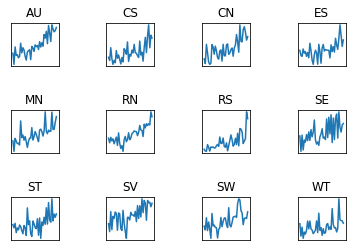

In [15]:
aaci = aaci.set_index('Year')
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
values = aaci.values
fig,sub = plt.subplots(3,4)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(aaci.columns[i])

/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Year', ylabel='Yield'>

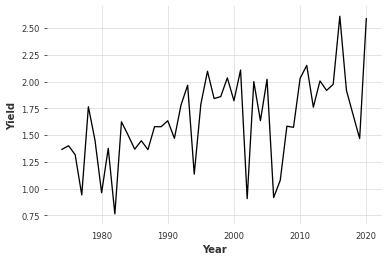

In [123]:
original = final_data[['Year', 'Yield']]
sn.lineplot(original['Year'], original['Yield'])

# Outlier Detection

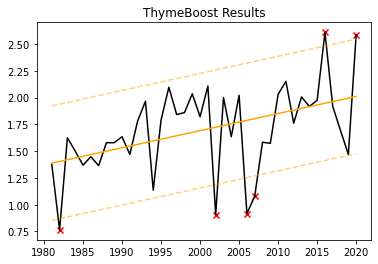

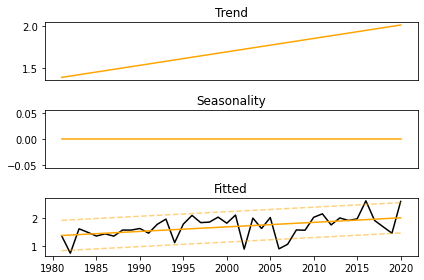

In [154]:
from ThymeBoost import ThymeBoost as tb
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(final_data['Yield'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                      #  seasonal_period=25,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
boosted_model.plot_components(output)

The result above that there IS an outlier. Hence, we need to solve this before proceeding to the modelling process

In [155]:
## Handling Outlier
final_data['Yield'].loc[1982] = np.nan
final_data['Yield'].loc[1994] = np.nan
final_data['Yield'].loc[2002] = np.nan
final_data['Yield'].loc[2006] = np.nan
final_data['Yield'].loc[2007] = np.nan
final_data['Yield'].loc[2016] = np.nan
final_data['Yield'].loc[2018] = np.nan
final_data['Yield'].loc[2019] = np.nan
final_data['Yield'].loc[2020] = np.nan

In [156]:
#Linear Interpolation : final_data.interpolate().head()
#Spline Interpolation
final_data.interpolate(method='spline',order=3).head()

,Yield,Planted,AU_ALL,CS_ALL,EN_ALL,ES_ALL,MB_ALL,MN_ALL,RN_ALL,RS_ALL,...,ES_WI,MB_WI,MN_WI,RN_WI,RS_WI,SE_WI,ST_WI,SV_WI,SW_WI,WT_WI
Year,,,,,,,,,,,,,,,,,,,,,
1981,1.376496,11884.6,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.013465,-0.715201,0.000000,0.000000,0.000000
1982,1.357949,11519.7,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,...,0.000000,0.000000,0.000000,0.000000,0.00000,-0.641513,0.043719,0.000000,0.000000,0.000000
1983,1.624118,12799.5,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,...,1.198097,0.206157,0.000000,0.000000,0.00000,0.717042,0.207227,0.000000,-0.286570,0.000000
1984,1.500378,12044.9,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,...,-0.283743,0.324074,0.000000,0.294304,0.00000,0.605802,0.545126,-0.401749,-0.011464,-0.091303
1985,1.368707,11735.6,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,...,0.134474,-0.391836,0.490319,0.362322,-0.13024,-0.046661,-0.161557,0.138516,0.415375,1.027355


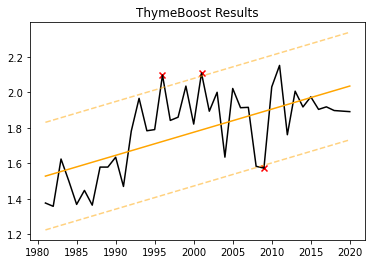

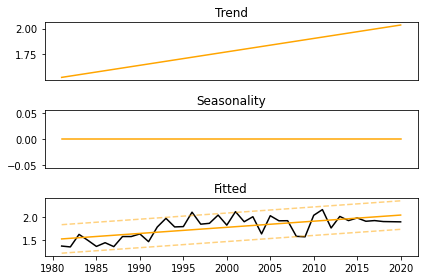

In [157]:
output = boosted_model.detect_outliers(final_data.interpolate(method='spline',order=3)['Yield'],
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                      #  seasonal_period=25,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
boosted_model.plot_components(output)

In [158]:
final_data = final_data.interpolate(method='spline',order=3)
# final_data['Yield']=np.log(final_data['Yield'])

# Modelling


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

2022-05-31 19:35:45.610521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 19:35:45.610851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [177]:
#Scaling The Data
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
scaled = scaler.fit_transform(final_data.values)
scaled[0]

array([-8.06857783e-01, -7.85812268e-01, -5.96172545e-01, -1.07155286e+00,
       -6.68477519e-02, -5.33380094e-01, -7.71471248e-01, -4.27896266e-01,
       -8.85442455e-01, -3.00530509e-01, -1.31110667e-01, -8.40321077e-01,
       -6.16524746e-01,  4.01336447e-01, -3.40624450e-01,  3.05610000e-01,
        3.66667025e-01,  1.26091549e+00, -1.06312378e+00, -6.93737632e-01,
       -5.63230511e-01,  8.07586599e-02, -1.25689849e+00, -1.65766226e+00,
        4.69463929e-01, -7.62374773e-01,  2.05662090e-01,  3.60656424e-01,
       -6.90723972e-02,  4.55166546e-01, -1.24998940e-03, -2.69826402e-01,
        1.39891891e+00,  6.44798079e-01, -9.01853889e-01,  3.55468452e-01,
        1.42733327e-01, -4.85079521e-01, -6.36394816e-01,  1.64944036e+00,
       -9.53366377e-01, -1.24835052e+00,  4.68271589e-01, -1.27980034e+00,
       -3.52800749e-01, -4.22446631e-01, -2.92728276e-01, -8.07666357e-01,
       -3.28309002e-01,  0.00000000e+00,  0.00000000e+00, -1.10331166e+00,
       -8.25582275e-01, -

In [161]:
#Supervised form
def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [178]:
timeSteps = 5

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
0,-0.806858,-0.785812,-0.596173,-1.071553,-0.066848,-0.533380,-0.771471,-0.427896,-0.885442,-0.300531,...,-1.010224,1.610470,2.057235,-0.610113,0.185064,-0.379286,0.426218,1.524034,3.132590,-0.629114
1,-2.337185,-1.897260,-0.947711,-1.533164,-0.712829,-0.399485,-1.987593,-0.983909,-1.090134,-1.838072,...,0.069217,0.049403,0.484673,-0.434349,-0.416426,0.775949,-0.503375,-1.220427,-0.398338,-0.836876
2,-0.187850,-0.160778,0.486527,0.394612,-0.838107,0.688643,-0.485563,-0.328380,-1.130755,-0.210406,...,-1.435234,0.085588,1.938522,-0.253155,-0.457527,-1.008052,0.040682,1.271272,2.358613,-0.301321
3,-0.497177,-1.009337,-0.733086,-0.456807,0.116182,-1.046610,-0.796293,-0.757326,-0.327536,-1.693621,...,-0.831663,-0.320844,-0.317692,-2.065643,0.084586,-1.727291,0.724375,0.110055,0.490997,-0.301303
4,-0.826327,-0.927356,-1.391250,-1.396830,-0.422471,-0.916080,-1.089609,-0.504588,-0.650535,-0.702487,...,-0.155783,-0.585720,-1.957148,-0.734671,-0.457527,0.140558,-1.914156,0.528354,1.604321,-0.162181


In [179]:
#Training and Testing Splitting
features = final_data.shape[1]
train_years = 25
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_years,:]
x_test = X[train_years:,:]
y_train = y[:train_years]
y_test = y[train_years:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25, 460) (10, 460) (25,) (10,)


In [180]:
#Convert Data Shape to Fit LSTM Model

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(25, 5, 92) (10, 5, 92)


Hyperparameter Tuning using Bayesian Optimization

In [64]:
import hp
import keras
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score

In [181]:
def build(hp):
    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                          'selu',
                          'elu'
                        ])

    num_rnn_layers = hp.Int(
                        'num_rnn_layers', 
                        min_value=0,
                        max_value=20,
                        default=3)

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.99,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=64,
                        default=32)
    
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation, recurrent_dropout = recurrent_dropout,input_shape=( timeSteps,x_train.shape[2])))
    model.add(Dense(1))
    # model.compile(loss='mse', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(
    #   hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
      hp.Float(
        'learning_rate',
        min_value=1e-10,
        max_value=1e-2,
        sampling='LOG',
        default=1e-6
            ),

        ),
        # loss=tf.losses.MeanSquaredError(),
        loss = 'mse',
        # metrics=[tf.metrics.MeanAbsoluteError()]
        metrics = ['mse']
    )
    return model

bayesian_opt_tuner = BayesianOptimization(
    build,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('/home/matthewfarant123/apu-fyp/keras-tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=100

bayesian_opt_tuner.search(x_train, y_train,epochs=n_epochs,
     validation_data=(x_test, y_test),
    #  batch_size=int(len(x_train)/2),
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 10s]
mse: 0.02910834178328514

Best mse So Far: 0.011932234279811382
Total elapsed time: 00h 00m 35s
INFO:tensorflow:Oracle triggered exit


In [182]:
#Defining the Model

# model = Sequential()
# model.add( LSTM( 256, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True ))
# model.add( LSTM( 128, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True ))
# model.add( LSTM( 64, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True ))
# model.add( LSTM( 32, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=True))
# model.add( LSTM( 16, input_shape = ( timeSteps,x_train.shape[2]),return_sequences=False))
# # model.add(Dropout(0.2))
# model.add(Dense(1))

# model.compile( loss = "mse", optimizer = "adam")

history =  model.fit( x_train,y_train,
                     validation_data = (x_test,y_test),
                     epochs = 100 ,
                     batch_size = 72,
                    #  callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                     verbose = 0,
                     shuffle = False)

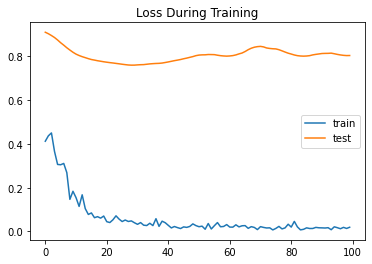

In [183]:
#Learning Curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss During Training")
plt.show()

In [184]:
#Scaling Back the Wheat Yield Data to Original Scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-91:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-91:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [206]:
#Predicted Year
df_forecast = pd.DataFrame({'Date':np.arange(start=2021-len(final_pred), stop=2021, step=1), 'Yield':final_pred})
df_forecast

,Date,Yield
0,2011,1.981208
1,2012,1.744032
2,2013,2.124026
3,2014,1.910423
4,2015,1.907056
5,2016,2.277056
6,2017,1.892232
7,2018,1.557684
8,2019,1.269301
9,2020,2.037722


In [192]:
final_data['Year'] = final_data.index

/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/matthewfarant123/fyp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Actual vs. Forecast (LSTM)'}, xlabel='Year', ylabel='Yield (t/ha)'>

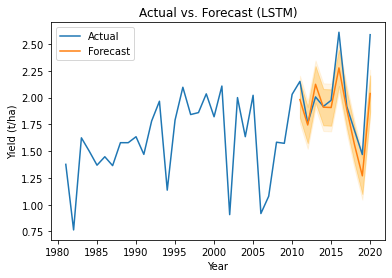

In [209]:
#Actual vs. Forecast Plot
original = final_data[['Year', 'Yield']]
lower_ci_99 = df_forecast['Yield']-2.576*(np.std(final_pred)/np.sqrt(10))
upper_ci_99 = df_forecast['Yield']+2.576*(np.std(final_pred)/np.sqrt(10))
lower_ci_95 = df_forecast['Yield']-1.96*(np.std(final_pred)/np.sqrt(10))
upper_ci_95 = df_forecast['Yield']+1.96*(np.std(final_pred)/np.sqrt(10))

sn.lineplot(original['Year'], original['Yield'],label='Actual').set(title='Actual vs. Forecast (LSTM)',ylabel='Yield (t/ha)')
sn.lineplot(df_forecast['Date'], df_forecast['Yield'],label='Forecast')
plt.fill_between(df_forecast['Date'], lower_ci_99, upper_ci_99, color='orange', alpha=.1)
plt.fill_between(df_forecast['Date'], lower_ci_95, upper_ci_95, color='orange', alpha=.3)
plt.legend(loc='upper left')
sn.lineplot()

In [210]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score

print('MAE: '+ str(mean_absolute_error(final_pred,actual_pred)))
print('RMSE: '+ str(np.sqrt(mean_squared_error(final_pred,actual_pred))))
print('MAPE: '+ str(mean_absolute_percentage_error(final_pred,actual_pred)))

MAE: 0.16196691115372797
RMSE: 0.22772342911053836
MAPE: 0.08618734097609346


# Darts

## Univariate

In [59]:
from darts import TimeSeries

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(final_data, 'Year', 'Yield')

# Set aside the last 36 months as a validation series
train, val = series[:-9], series[-9:]

In [60]:
from darts.models import ARIMA

model = ARIMA()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

2022-05-23 22:33:21 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


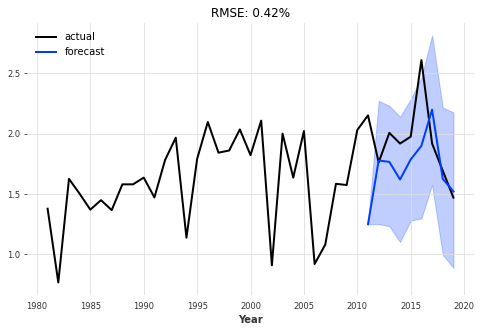

In [62]:
from darts.metrics import rmse
def eval_model(model):
    pred_series = model.predict(len(val), num_samples=1000)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("RMSE: {:.2f}%".format(rmse(pred_series, val)))
    plt.legend()


eval_model(model)

## Multivariate

In [63]:
from darts.models import RNNModel
from darts import TimeSeries
from darts.metrics import rmse

In [64]:
final_data.head()

,Yield,AU,CS,CN,ES,MB,MN,RN,RS,SE,ST,SV,SW,WT,Year
Year,,,,,,,,,,,,,,,
1981,1.376496,-0.087208,-0.084951,-0.258811,0.087191,-0.041700,-0.158683,-0.012887,-0.111130,-0.007505,0.058336,-0.134609,-0.084965,0.189143,1981
1982,0.764317,-0.357338,-0.196937,-0.433829,-0.108388,-0.010522,-0.538458,-0.211941,-0.156131,-0.452043,-0.043819,-0.345070,-0.214564,-0.333190,1982
1983,1.624118,0.064702,0.259954,0.297082,-0.146317,0.242856,-0.069399,0.022740,-0.165062,0.018552,0.095853,0.186962,0.207787,0.044916,1983
1984,1.500378,-0.141534,-0.128566,-0.025731,0.142605,-0.161209,-0.166435,-0.130824,0.011527,-0.410279,-0.190843,-0.291107,-0.238221,-0.426922,1984
1985,1.368707,-0.121609,-0.338231,-0.382139,-0.020478,-0.130815,-0.258032,-0.040343,-0.059485,-0.123720,-0.047249,0.061038,0.057917,-0.163531,1985


In [65]:
# Create a TimeSeries, specifying the time and value columns
series_yield = TimeSeries.from_dataframe(final_data, 'Year', 'Yield')
train_yield, val_yield = series_yield[:-10], series_yield[-10:]

series_AU = TimeSeries.from_dataframe(final_data, 'Year', 'AU')
train_AU, val_AU = series_AU[:-10], series_AU[-10:]

series_CS = TimeSeries.from_dataframe(final_data, 'Year', 'CS')
train_CS, val_CS = series_CS[:-10], series_CS[-10:]

series_CN = TimeSeries.from_dataframe(final_data, 'Year', 'CN')
train_CN, val_CN = series_CN[:-10], series_CN[-10:]

series_ES = TimeSeries.from_dataframe(final_data, 'Year', 'ES')
train_ES, val_ES = series_ES[:-10], series_ES[-10:]

series_MB = TimeSeries.from_dataframe(final_data, 'Year', 'MB')
train_MB, val_MB = series_MB[:-10], series_MB[-10:]

series_MN = TimeSeries.from_dataframe(final_data, 'Year', 'MN')
train_MN, val_MN = series_MN[:-10], series_MN[-10:]

series_RN = TimeSeries.from_dataframe(final_data, 'Year', 'RN')
train_RN, val_RN = series_RN[:-10], series_RN[-10:]

series_RS = TimeSeries.from_dataframe(final_data, 'Year', 'RS')
train_RS, val_RS = series_RS[:-10], series_RS[-10:]

series_SE = TimeSeries.from_dataframe(final_data, 'Year', 'SE')
train_SE, val_SE = series_SE[:-10], series_SE[-10:]

series_ST = TimeSeries.from_dataframe(final_data, 'Year', 'ST')
train_ST, val_ST = series_ST[:-10], series_ST[-10:]

series_SV = TimeSeries.from_dataframe(final_data, 'Year', 'SV')
train_SV, val_SV = series_SV[:-10], series_SV[-10:]

series_SW = TimeSeries.from_dataframe(final_data, 'Year', 'SW')
train_SW, val_SW = series_SW[:-10], series_SW[-10:]

series_WT = TimeSeries.from_dataframe(final_data, 'Year', 'WT')
train_WT, val_WT = series_WT[:-10], series_WT[-10:]


In [ ]:
rmse_results=[]
for i in range(30):
    model_lstm = RNNModel(
        model="LSTM",
        hidden_dim=100,
        dropout=0,
        batch_size=72,
        n_epochs=100,
        optimizer_kwargs={"lr": 1e-3},
        model_name="AACI_RNN",
        log_tensorboard=True,
        # random_state=42,
        # training_length=20,
        input_chunk_length=i,
        force_reset=True,
        save_checkpoints=True,
    )
    model_lstm.fit([train_yield,train_AU,train_CS,train_CN,train_ES,train_MB,train_MN,train_RN,train_RS,train_SE,train_ST,train_SV,train_SW,train_WT])
    pred_series = model_lstm.predict(len(val_yield),series=train_yield, num_samples=1000)
    rmse_results.append(rmse(pred_series, val_yield))

print(rmse_results)

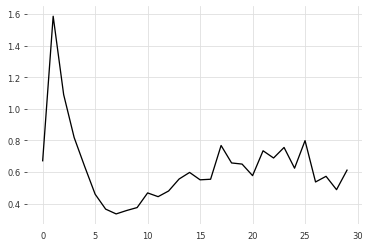

In [187]:
plt.plot(rmse_results)
plt.show()

In [188]:
print(rmse_results)

[0.6714354393937418, 1.5860422947961004, 1.090029296269481, 0.8184607798237928, 0.6356296987677977, 0.4597580430334773, 0.36536886260795126, 0.3350253457203982, 0.3565988791543251, 0.3752248605459192, 0.4679254169240201, 0.4442435185464838, 0.48021542586356314, 0.5559499200041744, 0.5975231666886137, 0.5508213630126795, 0.5544554453484446, 0.7681261056929072, 0.6575609195055232, 0.6503831201316009, 0.5773103797903844, 0.734633410098221, 0.688904493937928, 0.7555767150882606, 0.6244289316822299, 0.7989237866956369, 0.537252915998349, 0.5730255082048676, 0.4885039722478099, 0.6120905875896494]


In [189]:
model_lstm = RNNModel(
        model="LSTM",
        hidden_dim=128,
        n_rnn_layers=4,
        dropout=0,
        batch_size=72,
        n_epochs=300,
        optimizer_kwargs={"lr": 1e-3},
        model_name="AACI_RNN",
        log_tensorboard=True,
        # random_state=42,
        # training_length=20,
        input_chunk_length=7,
        force_reset=True,
        save_checkpoints=True,
    )
model_lstm.fit([train_yield,train_AU,train_CS,train_CN,train_ES,train_MB,train_MN,train_RN,train_RS,train_SE,train_ST,train_SV,train_SW,train_WT])

[2022-05-23 16:36:59,808] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 70 samples.
[2022-05-23 16:36:59,808] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 70 samples.
2022-05-23 16:36:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 70 samples.
[2022-05-23 16:36:59,823] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-23 16:36:59,823] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-23 16:36:59 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-05-23 16:36:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-05-23 16:36:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-05-23 16:36:59 pytorch_ligh

Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, loss=0.0434, v_num=logs, train_loss=0.0434]


In [190]:
pred = model_lstm.predict(n=10, series=train_yield,num_samples = 1000)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]           


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]           


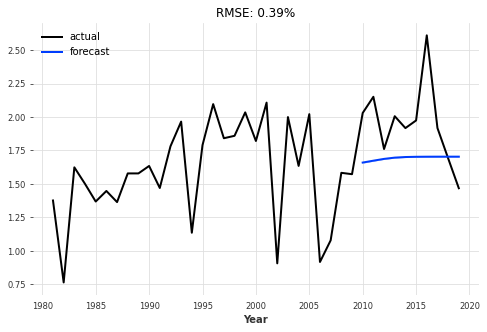

In [191]:
from darts.metrics import rmse
def eval_model(model):
    pred_series = model_lstm.predict(len(val_yield),series=train_yield, num_samples=1000)
    plt.figure(figsize=(8, 5))
    series_yield.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("RMSE: {:.2f}%".format(rmse(pred_series, val_yield)))
    plt.legend()


eval_model(model_lstm)

N-Beats

In [66]:
from darts.models import NBEATSModel
model_nbeats = NBEATSModel(input_chunk_length=5,output_chunk_length=1)

In [78]:
model_nbeats.fit([train_yield,train_AU,train_CS,train_CN,train_ES,train_MB,train_MN,train_RN,train_RS,train_SE,train_ST,train_SV,train_SW,train_WT],verbose=True)

[2022-05-23 22:53:07,159] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 336 samples.
[2022-05-23 22:53:07,159] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 336 samples.
2022-05-23 22:53:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 336 samples.
[2022-05-23 22:53:07,171] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-05-23 22:53:07,171] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progre

Epoch 99: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s, loss=0.00346, train_loss=0.00574] 


In [79]:
pred = model_nbeats.predict(n=10, series=train_yield)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -54.58it/s]  


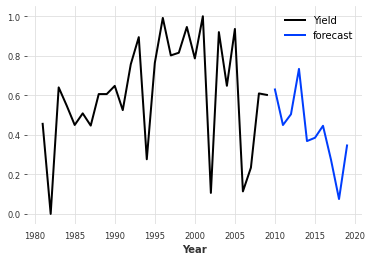

In [81]:
train_yield.plot()
pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

TCN

In [70]:
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood as LL

In [71]:
scaler_yield,scaler_AU,scaler_CS,scaler_CN,scaler_ES,scaler_MB,scaler_MN,scaler_RN,scaler_RS,scaler_SE,scaler_ST,scaler_SV,scaler_SW,scaler_WT = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()

In [73]:
yield_s = scaler_yield.fit_transform(train_yield)
AU_s = scaler_AU.fit_transform(train_AU)
CS_s = scaler_CS.fit_transform(train_CS)
CN_s = scaler_CN.fit_transform(train_CN)
ES_s = scaler_ES.fit_transform(train_ES)
MB_s = scaler_MB.fit_transform(train_MB)
MN_s = scaler_MN.fit_transform(train_MN)
RN_s = scaler_RN.fit_transform(train_RN)
RS_s = scaler_RS.fit_transform(train_RS)
SE_s = scaler_SE.fit_transform(train_SE)
ST_s = scaler_ST.fit_transform(train_ST)
SV_s = scaler_SV.fit_transform(train_SV)
SW_s = scaler_SW.fit_transform(train_SW)
WT_s = scaler_WT.fit_transform(train_WT)

In [75]:
model_tcn = TCNModel(input_chunk_length=5,
            output_chunk_length=1,
            likelihood=LL())
model_tcn.fit([yield_s,AU_s,CS_s,CN_s,ES_s,MB_s,MN_s,RN_s,RS_s,SE_s,ST_s,SV_s,SW_s,WT_s], epochs=100)

[2022-05-23 22:50:37,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 336 samples.
[2022-05-23 22:50:37,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 336 samples.
2022-05-23 22:50:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 336 samples.
[2022-05-23 22:50:37,698] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 1
[2022-05-23 22:50:37,698] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 1
2022-05-23 22:50:37 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 1
[2022-05-23 22:50:37,705] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-23 22:50:37,705] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-23 22:50:37 darts.models.forecasting.torch_forecasting_model INFO: Time ser

Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 51.25it/s, loss=0.174, train_loss=0.155] 


In [76]:
pred = model_tcn.predict(n=10, series=yield_s,num_samples=500)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -75.44it/s]   


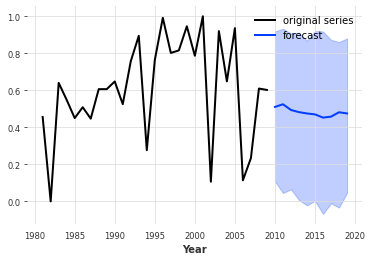

In [77]:
yield_s.plot(label='original series')
pred.plot(low_quantile=.1, high_quantile=.9, label='forecast')